In [2]:
# # Setup (PyTorch, paths, device, seeds)
# %load_ext autoreload
# %autoreload 2

from xray_models import (
    PneumoCNN, eval_one_epoch, fit,
    pick_threshold_youden, evaluate_with_threshold,
    XRayCNN, BatchNorm2d
)

from xray_helpers import (
    seed_all, compute_pos_weight,
    balance_val_train_split, plot_curves, get_dataloaders, download_xray_dataset
)

import os
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
seed_all(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda


In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2
EPOCHS = 15
PATIENCE = int(EPOCHS * 2 / 3)
LR = 1e-3

In [5]:
base_dir, train_dir, val_dir, test_dir = download_xray_dataset()

Train dir: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Train dir contents: ['PNEUMONIA', 'NORMAL']
Val dir: /kaggle/input/chest-xray-pneumonia/chest_xray/val
Val dir contents: ['PNEUMONIA', 'NORMAL']
Test dir: /kaggle/input/chest-xray-pneumonia/chest_xray/test
Test dir contents: ['PNEUMONIA', 'NORMAL']


Before split:
train/NORMAL: 1341
train/PNEUMONIA: 3875
val/NORMAL: 8
val/PNEUMONIA: 8


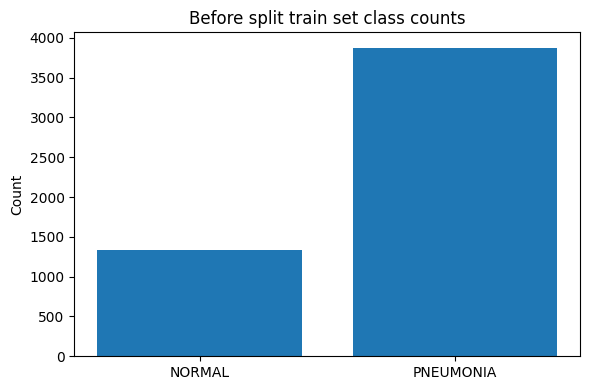

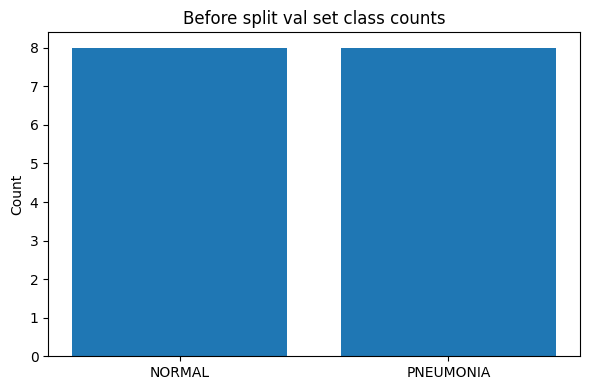

After split:
train/NORMAL: 1147
train/PNEUMONIA: 3300
val/NORMAL: 202
val/PNEUMONIA: 583


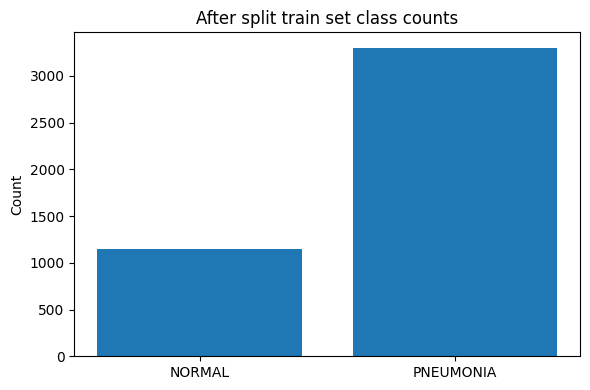

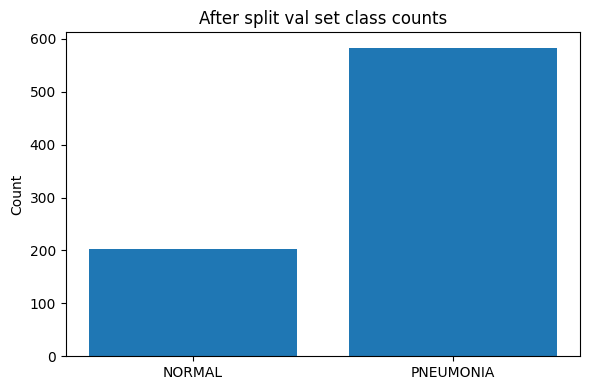

New dir: /tmp/chest_xray_split


In [6]:
new_base = balance_val_train_split(base_dir)
train_dir = os.path.join(new_base, 'train')
val_dir   = os.path.join(new_base, 'val')

In [7]:
# model = PneumoCNN()
# model = model.to(device)
# Build BN model
model_bn = XRayCNN(num_classes=1, norm_layer=BatchNorm2d).to(device)

data_sets, loaders = get_dataloaders(train_dir, val_dir, test_dir, BATCH_SIZE, NUM_WORKERS, IMG_SIZE)

print(f"Classes => {data_sets['train_ds'].classes}, , Class indices => {data_sets['train_ds'].class_to_idx}")

Classes => ['NORMAL', 'PNEUMONIA'], , Class indices => {'NORMAL': 0, 'PNEUMONIA': 1}


Train counts -> NEG(NORMAL)=1147, POS(PNEUMONIA)=3300, pos_weight=0.348


[Train] Epoch 1/15:   0%|          | 0/139 [00:00<?, ?it/s]

Input batch shape: torch.Size([32, 3, 224, 224])


[Eval] Epoch 1/15: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Train Loss: 0.1876, Accuracy: 0.8367, AUC: 0.9156, PR 0.9700
Val Loss: 0.2807, Accuracy: 0.8573, AUC: 0.9531, PR 0.9827


[Eval] Epoch 2/15: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Train Loss: 0.1435, Accuracy: 0.8887, AUC: 0.9485, PR 0.9819
Val Loss: 0.2057, Accuracy: 0.7631, AUC: 0.9600, PR 0.9861


[Eval] Epoch 3/15: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Train Loss: 0.1366, Accuracy: 0.8900, AUC: 0.9531, PR 0.9833
Val Loss: 0.2142, Accuracy: 0.8968, AUC: 0.9759, PR 0.9906


[Eval] Epoch 4/15: 100%|██████████| 25/25 [00:09<00:00,  2.62it/s]


Train Loss: 0.1143, Accuracy: 0.9112, AUC: 0.9684, PR 0.9889
Val Loss: 0.4689, Accuracy: 0.6013, AUC: 0.9740, PR 0.9900


[Eval] Epoch 5/15: 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


Train Loss: 0.1124, Accuracy: 0.9128, AUC: 0.9687, PR 0.9891
Val Loss: 0.1477, Accuracy: 0.9389, AUC: 0.9780, PR 0.9914


[Eval] Epoch 6/15: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Train Loss: 0.0993, Accuracy: 0.9238, AUC: 0.9763, PR 0.9918
Val Loss: 0.1812, Accuracy: 0.9261, AUC: 0.9877, PR 0.9951


[Eval] Epoch 7/15: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Train Loss: 0.0951, Accuracy: 0.9256, AUC: 0.9782, PR 0.9921
Val Loss: 0.7275, Accuracy: 0.7720, AUC: 0.9821, PR 0.9929


[Eval] Epoch 8/15: 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


Train Loss: 0.0890, Accuracy: 0.9339, AUC: 0.9809, PR 0.9928
Val Loss: 0.1089, Accuracy: 0.8828, AUC: 0.9904, PR 0.9965


[Eval] Epoch 9/15: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Train Loss: 0.0928, Accuracy: 0.9352, AUC: 0.9788, PR 0.9924
Val Loss: 0.0606, Accuracy: 0.9529, AUC: 0.9919, PR 0.9970


[Eval] Epoch 10/15: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


Train Loss: 0.0770, Accuracy: 0.9420, AUC: 0.9851, PR 0.9948
Val Loss: 0.3394, Accuracy: 0.8624, AUC: 0.9922, PR 0.9971


[Eval] Epoch 11/15: 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


Train Loss: 0.0767, Accuracy: 0.9433, AUC: 0.9859, PR 0.9952
Val Loss: 0.1132, Accuracy: 0.9529, AUC: 0.9933, PR 0.9976


[Eval] Epoch 12/15: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Train Loss: 0.0714, Accuracy: 0.9526, AUC: 0.9877, PR 0.9954
Val Loss: 0.0501, Accuracy: 0.9669, AUC: 0.9949, PR 0.9981


[Eval] Epoch 13/15: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


Train Loss: 0.0695, Accuracy: 0.9487, AUC: 0.9885, PR 0.9960
Val Loss: 0.0892, Accuracy: 0.9248, AUC: 0.9905, PR 0.9965


[Eval] Epoch 14/15: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Train Loss: 0.0726, Accuracy: 0.9440, AUC: 0.9872, PR 0.9957
Val Loss: 0.0590, Accuracy: 0.9592, AUC: 0.9922, PR 0.9972


[Eval] Epoch 15/15: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Train Loss: 0.0730, Accuracy: 0.9395, AUC: 0.9875, PR 0.9957
Val Loss: 0.2856, Accuracy: 0.8752, AUC: 0.9901, PR 0.9967
Training finished in 16.4 min. Best val AUC: 0.9949


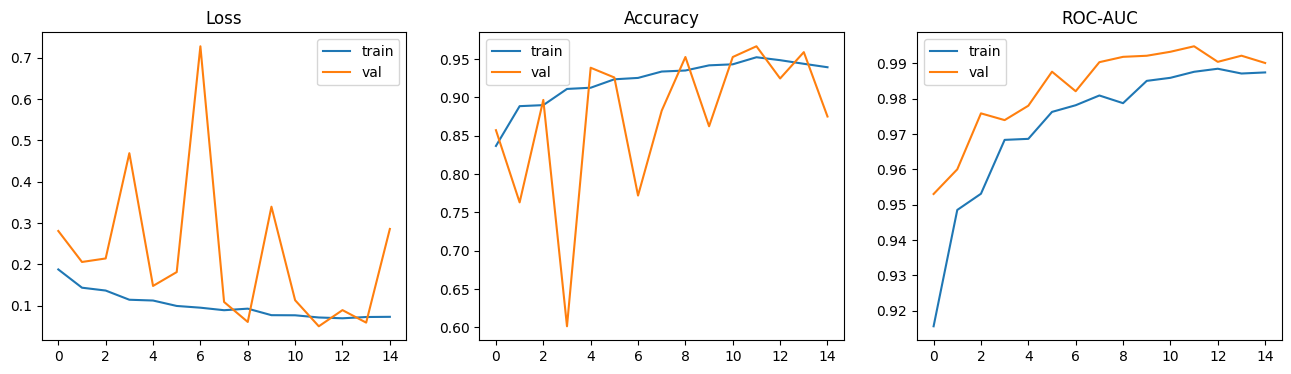

In [8]:
pos_weight = compute_pos_weight(data_sets['train_ds'])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

# targets = torch.tensor(data_sets['train_ds'].targets)          # ImageFolder -> 0/1 labels
# counts  = torch.bincount(targets, minlength=2)    # tensor([1147, 3300])
# N = counts.sum().item()
# C = 2
#
# class_weights = (N / (C * counts.float()))        # -> [~1.94, ~0.67]
# class_weights = class_weights.to(device)

# criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
## TODO: change ?
# criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW(model_bn.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

history, best_val_auc = fit(model_bn, loaders['train_loader'], loaders['val_loader'],
                            criterion, optimizer, device, scheduler, epochs=EPOCHS, patience=PATIENCE)

plot_curves(history)

In [9]:
_, _, _, va_auc, va_probs, va_targets = eval_one_epoch(model_bn, loaders['val_loader'], 1, criterion, device, 1)
best_thr = pick_threshold_youden(va_targets, va_probs)
print("Chosen threshold:", best_thr)

[Eval] Epoch 1/1: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]

Chosen threshold: 0.48061707615852356


[Eval] Epoch 1/15: 100%|██████████| 20/20 [00:11<00:00,  1.74it/s]

probs[:10] = [0.03563761 0.14948867 0.28768295 0.33582187 0.01410063 0.02324217
 0.14173442 0.5065768  0.5058123  0.36056012]
targets[:10] = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
TEST — loss: 0.4802 | acc@thr: 0.8205 | auc: 0.9551
Specificity: 0.5299 | Sensitivity: 0.9949 | Balanced Acc: 0.7624
PR-AUC from average_precision_score: 0.9689  | PR-AUC from sklearn.metrics: 0.9689
Confusion Matrix :
 [[124 110]
 [  2 388]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL     0.9841    0.5299    0.6889       234
   PNEUMONIA     0.7791    0.9949    0.8739       390

    accuracy                         0.8205       624
   macro avg     0.8816    0.7624    0.7814       624
weighted avg     0.8560    0.8205    0.8045       624



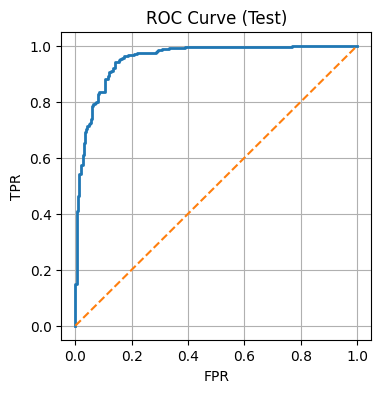

In [10]:
evaluate_with_threshold(model_bn, loaders['test_loader'], criterion, best_thr, device, EPOCHS)